## Improvement of Raw Transformation

### Setup of the Data

#### Initialization

In [1]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np
import time # For benchmarking

# Load data
tpr_file = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808/md_1.tpr"
xtc_file = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808/md_1_noPBC.xtc"

u = md.Universe(tpr_file, xtc_file)
u.trajectory[-1]
protein = u.select_atoms("protein")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 20000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
maskt = (t >= t_eq)

#### Functions

In [56]:
def get_mean_coords_mol(molecule, mask, group):
    # Get the Mean Coordinates of the molecule
    mean_coords = None
    chains = protein.fragments[3*molecule:3*molecule + 3]
    colmol = chains[0] + chains[1] + chains[2]
    colmol = colmol.select_atoms(group)
    for ts in u.trajectory[mask]:
        coords = colmol.positions / 10
        if mean_coords is None:
            mean_coords = coords.astype(float)
            n = 1
        else:
            n += 1
            mean_coords += (coords - mean_coords) / n

    # Ordering the z for unwrapping
    order = np.argsort(mean_coords[:, 2])
    return mean_coords[order]

def mean_com(mask, group = "backbone"):
    fib_mean = None
    fib = protein.select_atoms(group)
    for ts in u.trajectory[mask]:
        com = fib.center_of_mass() / 10
        if fib_mean is None:
            fib_mean = com
            n = 1
        else:
            n += 1
            fib_mean += (com - fib_mean) / n
    
    return com[0], com[1], com[2]

def clean_phi(y, x):
    # Get the phi effectively getting rid of the jumps
    phi_p = np.atan2(y, x)
    phi_uw = np.unwrap(phi_p)
    return phi_uw

def cyl_proj(molecule, y_fun, x_fun):
    z = molecule[:, 2]
    x = molecule[:, 0] - x_fun(z)
    y = molecule[:, 1] - y_fun(z)

    r = np.sqrt(y**2 + x**2)
    phi = clean_phi(y, x)
    return r, phi, z

def linfitandr2(x, y):
    fit_res = np.polyfit(x, y, 1, full=True) 
    m, b = fit_res[0]
    # R2
    SSE = fit_res[1][0] 
    SST = np.sum((y - np.mean(y)) ** 2) 
    R2 = 1 - SSE/SST
    return m, b, R2

### Center of the Fibril - Line Approximation

In [19]:
x_cfp, y_cfp, _ = mean_com(maskt) # Center of Mass

# Line through z-axis
x_cf = lambda z: x_cfp
y_cf = lambda z: y_cfp

### One Molecule

In [57]:
mol = 14
molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")
rad_mol, phi_mol, z_mol = cyl_proj(molecule_mean, y_cf, x_cf)

# Filter near 0 atoms
r_min = 0.5 #nm
mask_radmin = (rad_mol > r_min)
rad_mol = rad_mol[mask_radmin]
phi_mol = phi_mol[mask_radmin]
z_mol = z_mol[mask_radmin]

# Bin Catalogation - Radius
bins = 5
cat_bins = np.linspace(rad_mol.min(), rad_mol.max(), bins+1)
bin_ids = np.digitize(rad_mol, cat_bins) - 1
bin_rad = 0.5 * (cat_bins[:-1] + cat_bins[1:])

View $x,y,z$ visualization of centered molecule. Fix the unwrapping.

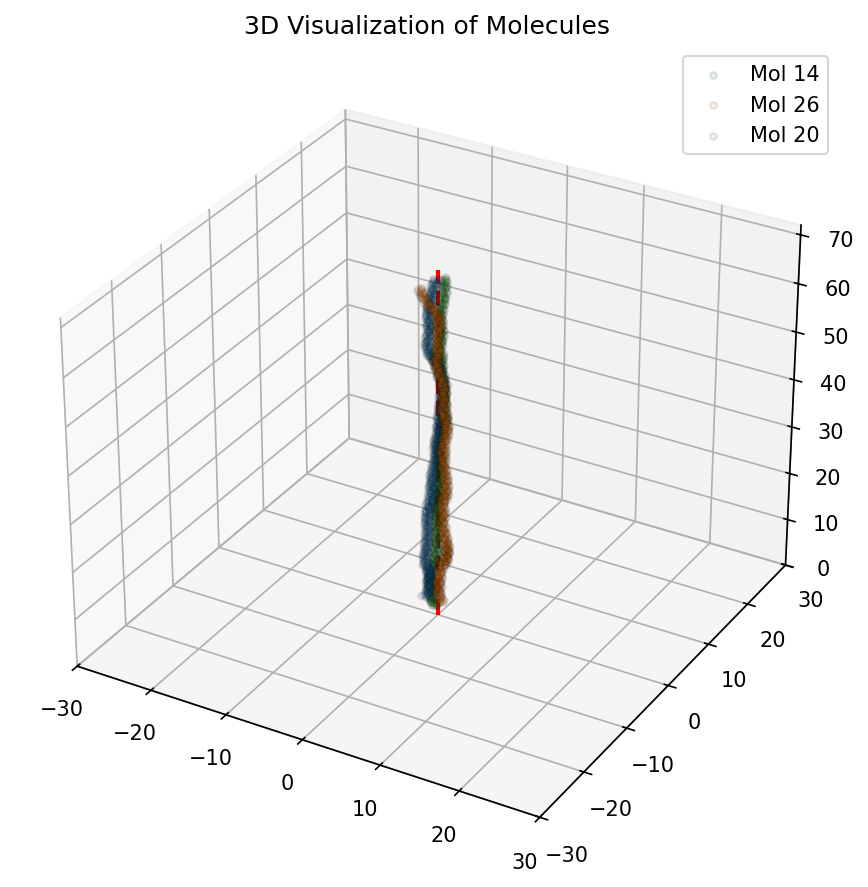

In [67]:
mols = [14, 26, 20]

fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap("tab10")   # Coloring
colors = [cmap(j) for j in range(len(mols))]
for i, mol in enumerate(mols):
    molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")

    x = molecule_mean[:, 0] - x_cfp
    y = molecule_mean[:, 1] - y_cfp
    z = molecule_mean[:, 2]

    ax.scatter(x, y, z, s=10, color=colors[i], edgecolor='k', alpha=0.1, label=f'Mol {mol}')


ax.set_xlim3d([-30, 30])
ax.set_ylim3d([-30, 30])
ax.set_zlim3d([0, 72])

# Centerline of fibril
z_line = np.linspace(0, 72, 100)
ax.plot(np.zeros_like(z_line), np.zeros_like(z_line), z_line, color='r', linestyle='dashed', linewidth=2)

plt.title("3D Visualization of Molecules")
plt.tight_layout()
plt.legend()
plt.show()

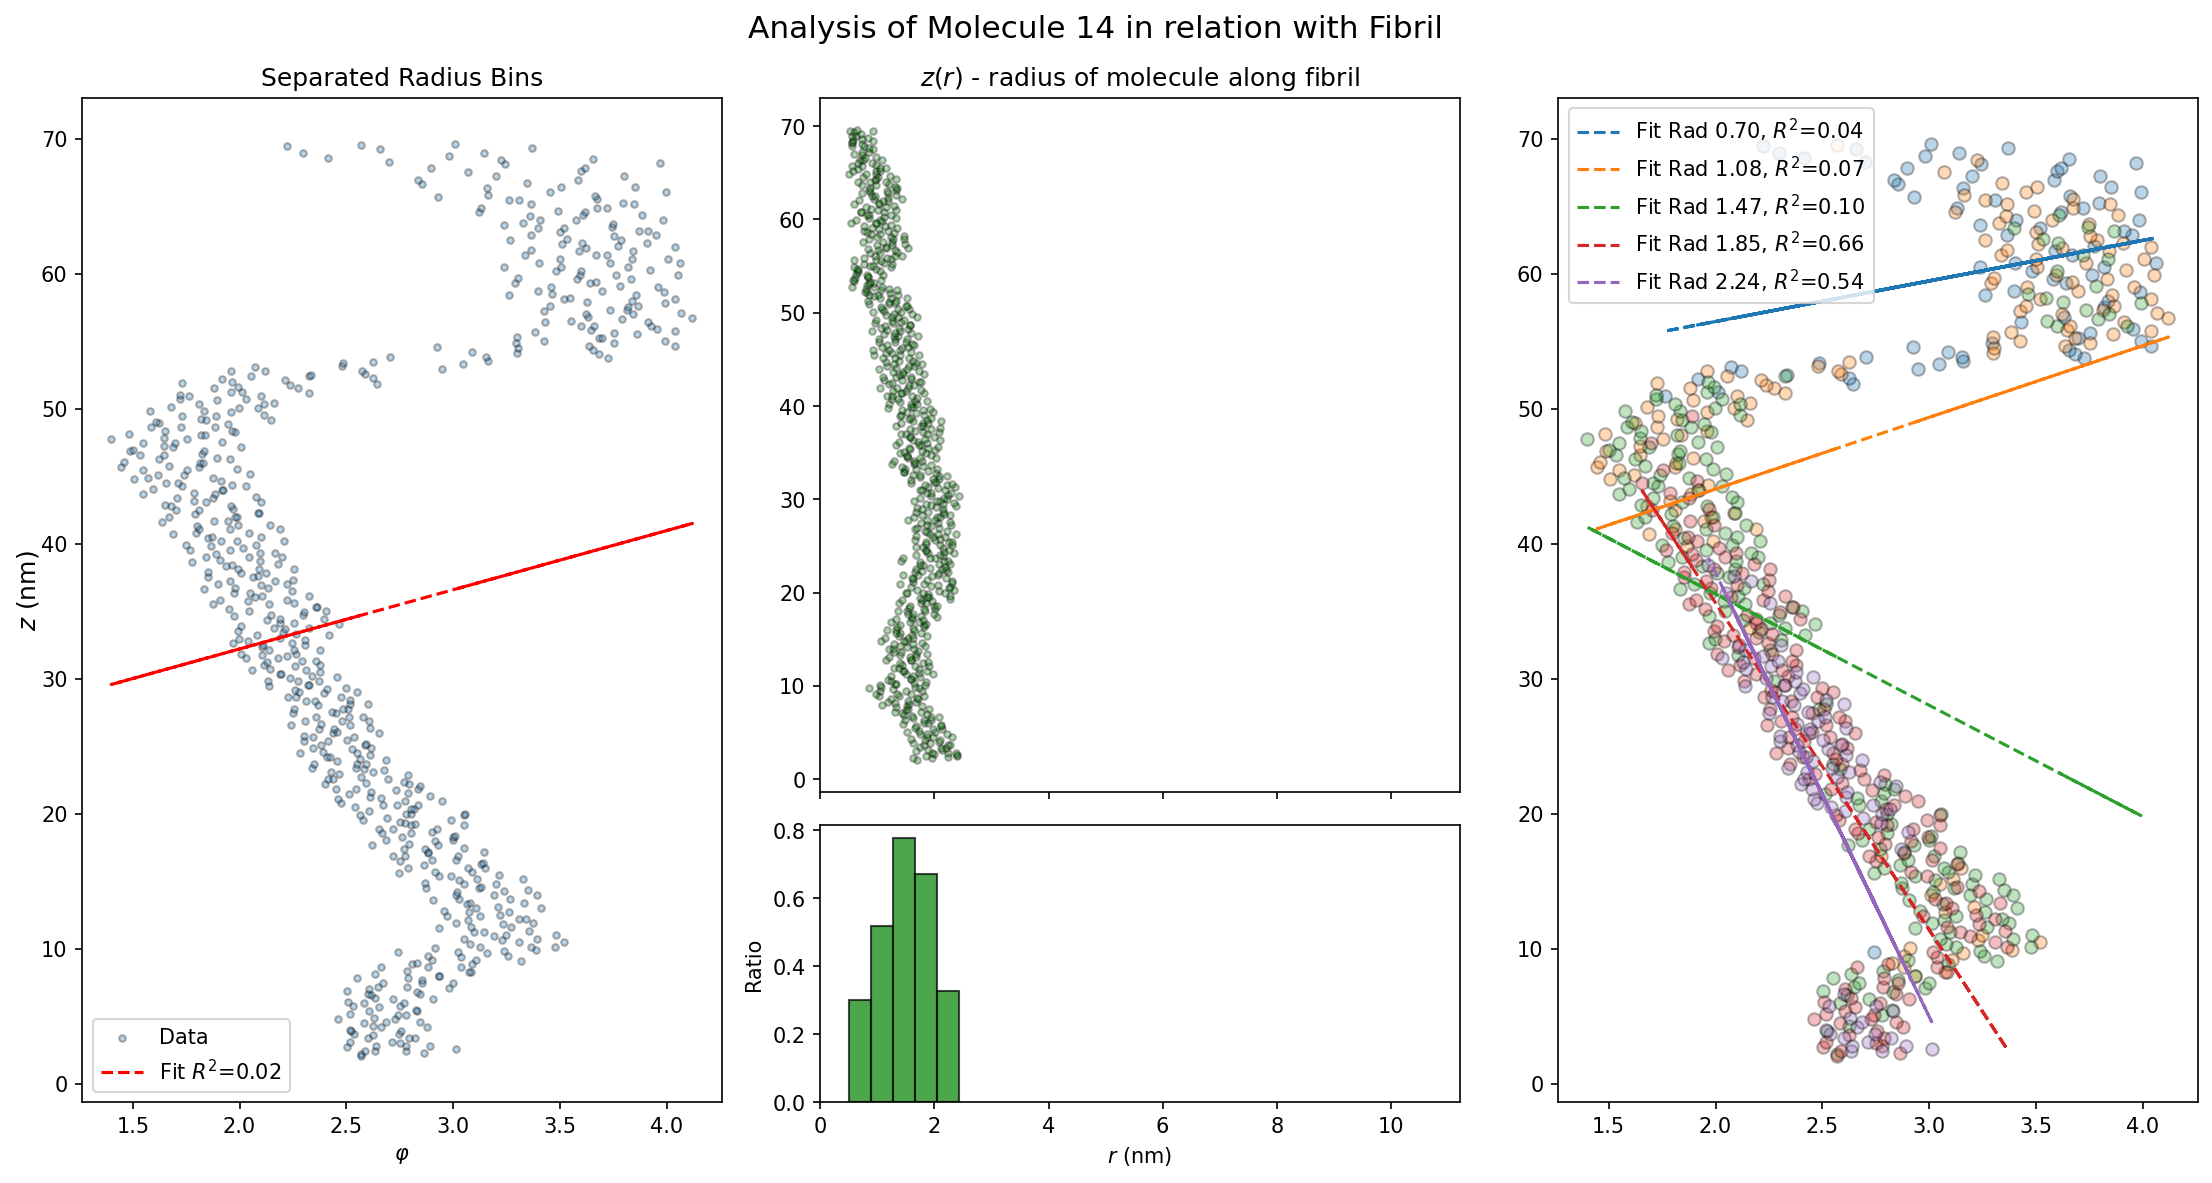

In [59]:
# --- Build figure with GridSpec: left & middle span both rows; right column is split ---
fig = plt.figure(figsize=(15, 8), dpi=150)

gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.4])

ax0 = fig.add_subplot(gs[:, 0])   # left: per-chain phi(z)
ax1 = fig.add_subplot(gs[0, 1])   # middle: combined phi(z) + fit
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)   # top-right: z vs r
ax3 = fig.add_subplot(gs[:, 2])  # bottom-right: histogram of r

# --- Left: Angle Projection of Molecule & Fit ---
ax0.scatter(phi_mol, z_mol, s=10, edgecolor='k', alpha=0.3, label="Data")
m, b, R2 = linfitandr2(phi_mol, z_mol)
fit = np.poly1d((m, b))
ax0.plot(phi_mol, fit(phi_mol), linestyle='dashed', color='r', label=rf"Fit $R^2$={R2:.2f}")
ax0.set_title("All chains combined")
ax0.set_xlabel(r"$\varphi$")
ax0.legend()

# --- Middle: Radius & Histogram ---
# Radius
ax1.scatter(rad_mol, z_mol, s=10, color='g', edgecolor='k', alpha=0.3)
ax1.set_xlim(0, np.sqrt(xd**2 + yd**2) / 2)
ax1.set_title(r"$z(r)$ - radius of molecule along fibril")
ax1.tick_params(labelbottom=False)

# Histogram
ax2.hist(rad_mol, bins=bins, color='g', edgecolor='k', alpha=0.7, density=True)
ax2.set_xlabel(r"$r$ (nm)")
ax2.set_ylabel("Ratio")
ax2.set_xlim(ax2.get_xlim())

# --- Right: Separation and fit of each Group ---
cmap = plt.get_cmap("tab10")   # Coloring
colors = [cmap(j) for j in range(bins)]
for i in range(bins):
    maskr = bin_ids == i
    sample_phi = phi_mol[maskr]
    sample_z = z_mol[maskr]

    color = colors[i]

    ax3.scatter(sample_phi, sample_z, edgecolor='k', color=color, alpha=0.3)

    # Fit Analysis
    m, b, R2 = linfitandr2(sample_phi, sample_z)
    fit = np.poly1d((m, b))
    ax3.plot(sample_phi, fit(sample_phi), linestyle='dashed', color=color, label=rf"Fit Rad {bin_rad[i]:.2f}, $R^2$={R2:.2f}")

ax0.set_title("Separated Radius Bins")
ax0.set_xlabel(r"$\varphi$")
ax3.legend()

# --- Shared y label & overall title ---
fig.supylabel(r"$z$ (nm)")
plt.suptitle(f"Analysis of Molecule {mol} in relation with Fibril", fontsize=15)
plt.tight_layout()
plt.show()


Its like you were to generate `bins` amount of molecule sample sets from this single molecule and the divition of it in different radius, but one thing that I think most be considered is that this samples are not independent, so perhaps this is not an effective approach into this.

### Computation of $\tau(r)$ - End-Cut Molecules

For this, we will implement this cutting of the ends, and then represent the radius as the mean, $\langle r \rangle$, to see if theres better improvement in the results we get.

In [68]:
tot_mol = int((protein.fragindices[-1] + 1)/3)
tau = np.zeros(tot_mol)
r2s = np.zeros(tot_mol)
mean_rad = np.zeros(tot_mol)
err_rad = np.zeros((2, tot_mol)) # Shape for errobars
r_min = 2 #nm

for mol in range(tot_mol):
    # Mean
    molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")
    
    # Cylindrical Coordinates
    rad, phi, z = cyl_proj(molecule_mean, y_cf, x_cf)

    # Filter near 0
    mask_radmin = (rad > r_min)
    rad = rad[mask_radmin]
    phi = phi[mask_radmin]
    z = z[mask_radmin]

    if rad.size == 0:
        tau[mol] = np.nan
        r2s[mol] = np.nan
        mean_rad[mol] = np.nan
        err_rad[:, mol] = np.nan, np.nan
        continue

    # Fit and R2
    tau[mol], _, r2s[mol] = linfitandr2(phi, z)

    # Radius Data
    mean_rad[mol] = np.mean(rad)
    err_rad[:, mol] = mean_rad[mol] - min(rad), max(rad) - mean_rad[mol] # Error (Difference) Lower and Higher

Lets see if we can improve the data quality by filtering the "bad" fittings (one which have a jump). The most reasonable and straightforward method that comes to mind is by evaluating the linear fit (worse fit would correspond to jumps which cannot be correctly fitted).

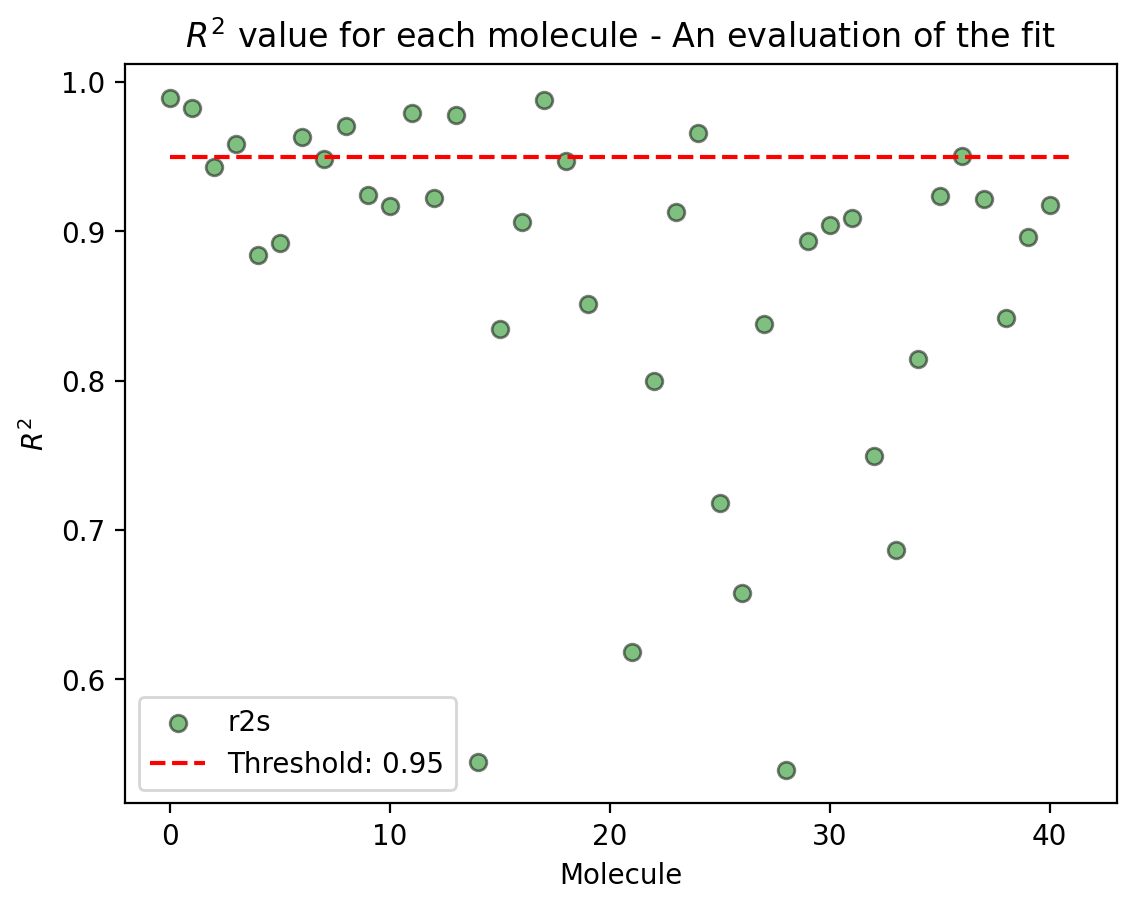

In [73]:
filt_r2 = 0.95

# Visualization of the Rsquared
plt.figure(dpi=200)
plt.scatter(np.arange(0, tot_mol), r2s, color='g', edgecolor='k', alpha=0.5, label='r2s')
plt.hlines(filt_r2, 0, tot_mol, color='r', linestyle='dashed', label=f'Threshold: {filt_r2}')
plt.xlabel(r'Molecule')
plt.ylabel(r'$R^2$')
plt.title(r"$R^2$ value for each molecule - An evaluation of the fit")
plt.legend()
plt.show()

# Filter data
maskr2 = (r2s >= filt_r2) 
tau_filt = tau[maskr2]
mean_rad_filt = mean_rad[maskr2]
err_rad_filt = err_rad[:,maskr2]

Lets see the result and the comparison evaluating the $R^2$ filtering.

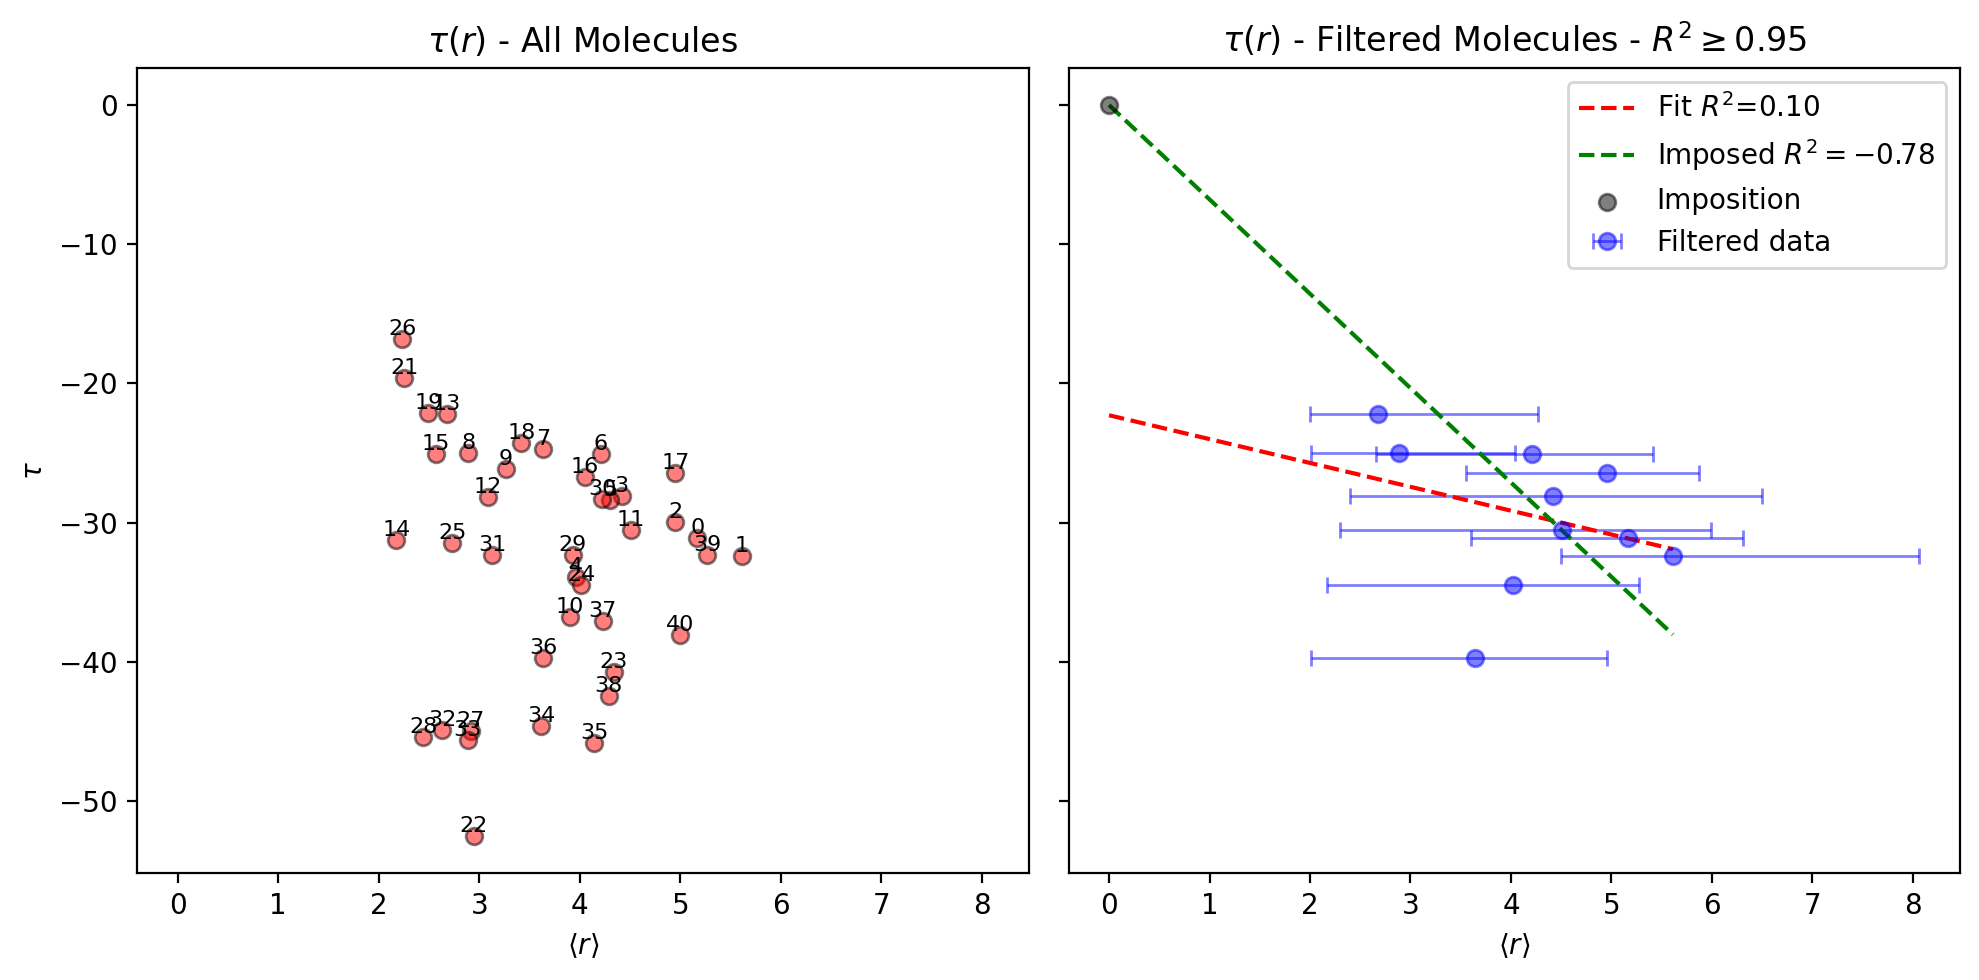

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharex=True, sharey=True)

# --- Left: original tau ---
axs[0].scatter(mean_rad, tau, color='r', edgecolor='k', alpha=0.5)

for i, (x, y) in enumerate(zip(mean_rad, tau)):
    axs[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

axs[0].set_xlabel(r'$\langle r \rangle$')
axs[0].set_ylabel(r'$\tau$')
axs[0].set_title(r"$\tau(r)$ - All Molecules")

# --- Right: filtered tau ---
# axs[1].scatter(mean_rad_filt, tau_filt, color='b', edgecolor='k', alpha=0.5, label='Filtered data')
axs[1].errorbar(mean_rad_filt, tau_filt, xerr=err_rad_filt, fmt='o', color='b', mfc='b', mec='b', alpha=0.5, capsize=3, elinewidth=1, label='Filtered data')

# Fit and Evaluation
fit_res = np.polyfit(mean_rad_filt, tau_filt, 1, full=True)
m, b = fit_res[0]
# R2
SSE = fit_res[1][0]
diff = tau_filt - np.mean(tau_filt)
square_diff = diff ** 2
SST = np.sum(square_diff)
r2filt = 1 - SSE/SST

fit = np.poly1d((m, b))
r_plt = np.linspace(0, max(mean_rad_filt), 100)
axs[1].plot(r_plt, fit(r_plt), linestyle='dashed', color='r', label=rf"Fit $R^2$={r2filt:.2f}")

# --- Test: Impose (0,0) ---
# Use a more raw approach, from stack
r_fit_0 = mean_rad_filt[:,np.newaxis]
m0, _, _, _ = np.linalg.lstsq(r_fit_0, tau_filt)
tau_fit = m0 * mean_rad_filt
SSE = np.sum((tau_filt - tau_fit)**2)
SST = np.sum((tau_filt - np.mean(tau_filt))**2)
r2imp = 1 - SSE / SST


axs[1].plot(r_plt, m0*r_plt, linestyle='dashed', color='g', label=rf'Imposed $R^2={r2imp:.2f}$')
axs[1].scatter([0],[0], color='k', edgecolor='k', alpha=0.5, label='Imposition', zorder=3)

axs[1].set_xlabel(r'$\langle r \rangle$')
axs[1].set_title(rf"$\tau(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
axs[1].legend()

plt.tight_layout()
plt.show()